In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e2-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

pilot_length_index = 2
pilot_length=pilot_length_array[pilot_length_index]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
num_samples = 1000
sample_range = range(400, 600)

Sparse Bayesian Learning (SBL)

In [4]:
def sbl_algorithm(theta, y, noise_var, max_iter=500, stopping_criterion=1e-4):
    # Sparse Bayesian Learning (SBL) for Multiple Measurement Vectors (MMV).

    M = y.shape[1]  # Number of antennas (columns of y)

    L = theta.shape[0]  # Pilot Length (rows of theta)
    N = theta.shape[1] # Number of MTDs (columns of theta)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess: identity matrix

    # Iterative update process
    for t in range(max_iter):
       # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
        mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

        # Compute gamma update using the derived formula
        gamma_new = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.real(np.diag(Sigma_x))

        # Ensure non-negativity for numerical stability
        gamma_new = np.maximum(gamma_new, 1e-8)

        # Check for convergence: if change is below threshold, stop iterations
        if np.linalg.norm(gamma_new - np.diag(Gamma)) < stopping_criterion:
            print(f"Converged after {t+1} iterations")
            break

        # Update Gamma with new values
        Gamma = np.diagflat(gamma_new)

    # Return final estimates
    return mu_x, np.diag(Gamma)


In [5]:
# Placeholder arrays for results
z_res = np.zeros((num_samples, len(snr_db_array), device_count, M), dtype=np.complex128)  # Z estimates
gamma_res = np.zeros((num_samples, len(snr_db_array), device_count), dtype=bool)  # Gamma support

hr_res = np.zeros((num_samples, len(snr_db_array)))         # HR
fr_res = np.zeros((num_samples, len(snr_db_array)))         # FR
srr_res = np.zeros((num_samples, len(snr_db_array)))        # SRR
precision_res = np.zeros((num_samples, len(snr_db_array)))  # Precision
recall_res = np.zeros((num_samples, len(snr_db_array)))     # Recall
f1_res = np.zeros((num_samples, len(snr_db_array)))         # F1
nmse_res = np.zeros((num_samples, len(snr_db_array)))       # NMSE

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(sample_range, desc="Processing Samples", position=0):
    theta = all_theta[sample_index, pilot_length_index, :pilot_length]
    gamma = all_gamma[sample_index]  # Ground truth gamma values (true support)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for snr_db_index in tqdm(range(len(snr_db_array)), desc="Processing SNR Levels", leave=False, position=1):
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr_db = snr_db_array[snr_db_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and SNR level
        z_result, gamma_result = sbl_algorithm(theta, received_signal, noise_power)

        # Zero-out results with low gamma values
        z_result[gamma_result <= 0.05] = 0
        z_res[sample_index, snr_db_index, :, :] = z_result
        gamma_result_bool = gamma_result > 0.05
        gamma_res[sample_index, snr_db_index, :] = gamma_result_bool

        # Compute number of active/inactive devices from ground truth
        active_devices = np.sum(gamma == 1)
        inactive_devices = np.sum(gamma == 0)

        # Hit rate: percentage of correctly identified active devices
        hr_res[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # False alarm rate: percentage of inactive devices wrongly detected as active
        fr_res[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Support recovery rate: proportion of correctly identified active devices
        srr_res[sample_index, snr_db_index] = (
            np.sum((gamma_result_bool == 1) & (gamma == 1)) /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Classification metrics: TP, FP, FN
        TP = np.sum((gamma_result_bool == 1) & (gamma == 1))
        FP = np.sum((gamma_result_bool == 1) & (gamma == 0))
        FN = np.sum((gamma_result_bool == 0) & (gamma == 1))

        # Precision: proportion of predicted active devices that are actually active
        precision_res[sample_index, snr_db_index] = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall: proportion of actual active devices that are correctly identified
        recall_res[sample_index, snr_db_index] = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1 Score: harmonic mean of precision and recall
        if (precision_res[sample_index, snr_db_index] + recall_res[sample_index, snr_db_index]) > 0:
            f1_res[sample_index, snr_db_index] = (
                2 * precision_res[sample_index, snr_db_index] * recall_res[sample_index, snr_db_index]
                /
                (precision_res[sample_index, snr_db_index] + recall_res[sample_index, snr_db_index])
            )
        else:
            f1_res[sample_index, snr_db_index] = 0

        # Normalized Mean Squared Error: compares estimated and true z vectors for active devices
        nmse_res[sample_index, snr_db_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )


Processing Samples:   0%|          | 1/200 [01:52<6:11:49, 112.11s/it]

Converged after 403 iterations



Processing Samples:   2%|▏         | 3/200 [05:39<6:11:31, 113.16s/it]

Converged after 453 iterations



Processing Samples:   2%|▎         | 5/200 [09:29<6:10:27, 113.99s/it]

Converged after 421 iterations



Processing Samples:   3%|▎         | 6/200 [11:23<6:08:38, 114.01s/it]

Converged after 423 iterations



Processing Samples:   6%|▌         | 12/200 [22:55<5:59:56, 114.87s/it]

Converged after 449 iterations



Processing Samples:   6%|▋         | 13/200 [24:51<5:59:09, 115.24s/it]

Converged after 499 iterations



Processing Samples:   8%|▊         | 15/200 [28:37<5:52:29, 114.32s/it]

Converged after 479 iterations



Processing Samples:  10%|█         | 21/200 [40:09<5:41:50, 114.59s/it]

Converged after 461 iterations



Processing Samples:  11%|█         | 22/200 [42:04<5:40:21, 114.73s/it]

Converged after 449 iterations



Processing Samples:  12%|█▎        | 25/200 [47:49<5:34:46, 114.78s/it]

Converged after 494 iterations



Processing Samples:  15%|█▌        | 30/200 [57:23<5:24:14, 114.44s/it]

Converged after 470 iterations



Processing Samples:  17%|█▋        | 34/200 [1:05:02<5:15:06, 113.89s/it]

Converged after 429 iterations



Processing Samples:  20%|█▉        | 39/200 [1:14:36<5:05:02, 113.68s/it]

Converged after 364 iterations



Processing Samples:  20%|██        | 41/200 [1:18:26<5:02:49, 114.28s/it]

Converged after 406 iterations



Processing Samples:  22%|██▎       | 45/200 [1:26:09<4:57:59, 115.35s/it]

Converged after 461 iterations



Processing Samples:  31%|███       | 62/200 [1:59:03<4:25:31, 115.44s/it]

Converged after 450 iterations



Processing Samples:  34%|███▍      | 69/200 [2:12:36<4:13:26, 116.08s/it]

Converged after 491 iterations



Processing Samples:  36%|███▋      | 73/200 [2:20:19<4:05:19, 115.90s/it]

Converged after 454 iterations



Processing Samples:  38%|███▊      | 75/200 [2:24:08<4:00:28, 115.43s/it]

Converged after 463 iterations



Processing Samples:  39%|███▉      | 78/200 [2:29:54<3:53:24, 114.79s/it]

Converged after 436 iterations



Processing Samples:  40%|████      | 81/200 [2:35:46<3:50:41, 116.32s/it]

Converged after 483 iterations



Processing Samples:  42%|████▎     | 85/200 [2:43:31<3:42:50, 116.26s/it]

Converged after 446 iterations



Processing Samples:  44%|████▍     | 89/200 [2:51:15<3:35:29, 116.48s/it]

Converged after 479 iterations



Processing Samples:  45%|████▌     | 90/200 [2:53:07<3:30:53, 115.03s/it]

Converged after 422 iterations



Processing Samples:  48%|████▊     | 96/200 [3:04:45<3:20:45, 115.82s/it]

Converged after 447 iterations



Processing Samples:  51%|█████     | 102/200 [3:16:19<3:08:09, 115.20s/it]

Converged after 470 iterations



Processing Samples:  66%|██████▌   | 131/200 [4:12:29<2:13:11, 115.82s/it]

Converged after 500 iterations



Processing Samples:  68%|██████▊   | 137/200 [4:24:01<2:01:01, 115.26s/it]

Converged after 474 iterations



Processing Samples:  71%|███████   | 142/200 [4:33:39<1:51:11, 115.03s/it]

Converged after 428 iterations



Processing Samples:  72%|███████▏  | 144/200 [4:37:26<1:46:35, 114.21s/it]

Converged after 463 iterations



Processing Samples:  73%|███████▎  | 146/200 [4:41:20<1:44:00, 115.57s/it]

Converged after 500 iterations



Processing Samples:  74%|███████▍  | 148/200 [4:45:09<1:39:24, 114.71s/it]

Converged after 441 iterations



Processing Samples:  75%|███████▌  | 150/200 [4:49:03<1:36:36, 115.93s/it]

Converged after 497 iterations



Processing Samples:  78%|███████▊  | 155/200 [4:58:45<1:27:11, 116.26s/it]

Converged after 449 iterations



Processing Samples:  78%|███████▊  | 156/200 [5:00:38<1:24:33, 115.32s/it]

Converged after 466 iterations



Processing Samples:  81%|████████  | 162/200 [5:12:17<1:13:26, 115.96s/it]

Converged after 456 iterations



Processing Samples:  82%|████████▎ | 165/200 [5:18:09<1:08:06, 116.76s/it]

Converged after 498 iterations



Processing Samples:  84%|████████▍ | 169/200 [5:25:55<1:00:23, 116.90s/it]

Converged after 487 iterations



Processing Samples:  86%|████████▌ | 171/200 [5:29:43<55:43, 115.29s/it]

Converged after 408 iterations



Processing Samples:  86%|████████▋ | 173/200 [5:33:37<52:14, 116.11s/it]

Converged after 479 iterations



Processing Samples:  88%|████████▊ | 175/200 [5:37:26<48:07, 115.50s/it]

Converged after 463 iterations



Processing Samples:  88%|████████▊ | 176/200 [5:39:23<46:21, 115.89s/it]

Converged after 493 iterations



Processing Samples:  89%|████████▉ | 178/200 [5:43:13<42:12, 115.13s/it]

Converged after 465 iterations



Processing Samples:  90%|████████▉ | 179/200 [5:45:09<40:24, 115.46s/it]

Converged after 496 iterations



Processing Samples:  90%|█████████ | 180/200 [5:47:04<38:28, 115.44s/it]

Converged after 488 iterations



Processing Samples:  90%|█████████ | 181/200 [5:49:01<36:41, 115.85s/it]

Converged after 499 iterations



Processing Samples:  92%|█████████▎| 185/200 [5:56:43<28:51, 115.45s/it]

Converged after 400 iterations



Processing Samples:  94%|█████████▍| 188/200 [6:02:29<23:06, 115.55s/it]

Converged after 473 iterations



Processing Samples:  94%|█████████▍| 189/200 [6:04:22<21:04, 114.96s/it]

Converged after 483 iterations



Processing Samples:  98%|█████████▊| 195/200 [6:15:59<09:38, 115.76s/it]

Converged after 464 iterations



Processing Samples:  98%|█████████▊| 196/200 [6:17:52<07:39, 114.97s/it]

Converged after 458 iterations



Processing Samples: 100%|██████████| 200/200 [6:25:38<00:00, 115.69s/it]


In [7]:
# Compute the average across all samples for each SNR level
avg_hr = np.mean(hr_res, axis=0)         # HR
avg_srr = np.mean(srr_res, axis=0)       # SRR
avg_fr = np.mean(fr_res, axis=0)         # FR
avg_pr = np.mean(precision_res, axis=0)  # Precision
avg_re = np.mean(recall_res, axis=0)     # Recall
avg_f1 = np.mean(f1_res, axis=0)         # F1
avg_nmse = np.mean(nmse_res, axis=0)     # NMSE

# Print average results
print("Avg HR  :", avg_hr)
print("Avg SRR :", avg_srr)
print("Avg FR  :", avg_fr)
print("Avg PR  :", avg_pr)
print("Avg RE  :", avg_re)
print("Avg F1  :", avg_f1)
print("Avg NMSE:", avg_nmse)

Avg HR  : [11.195 15.045 18.39  19.815 19.98  20.   ]
Avg SRR : [0.04632625 0.07737087 0.12721943 0.18315147 0.19914935 0.2       ]
Avg FR  : [1.07868421 0.80157895 0.42921053 0.08894737 0.00263158 0.        ]
Avg PR  : [0.07120178 0.10035162 0.14002139 0.18536538 0.19952143 0.2       ]
Avg RE  : [0.11195 0.15045 0.1839  0.19815 0.1998  0.2    ]
Avg F1  : [0.08687374 0.12018376 0.15867553 0.19134639 0.19965356 0.2       ]
Avg NMSE: [0.12905378 0.08846138 0.04317036 0.01337113 0.00450858 0.00169319]


In [8]:
np.savez_compressed(
    '/content/drive/My Drive/Github/mtc-device-activation/data/results/e2-results-1000-sbl-snr-db-all-pilot-length-30-set-3.npz',
    z_res=z_res,
    gamma_res=gamma_res,
    hr_res=hr_res,
    fr_res=fr_res,
    srr_res=srr_res,
    precision_res=precision_res,
    recall_res=recall_res,
    f1_res=f1_res,
    nmse_res=nmse_res,
    avg_hr=avg_hr,
    avg_fr=avg_fr,
    avg_srr=avg_srr,
    avg_pr=avg_pr,
    avg_re=avg_re,
    avg_f1=avg_f1,
    avg_nmse=avg_nmse,
    pilot_length=pilot_length,
    snr_db_array=snr_db_array
)

print("All results have been saved")

All results have been saved


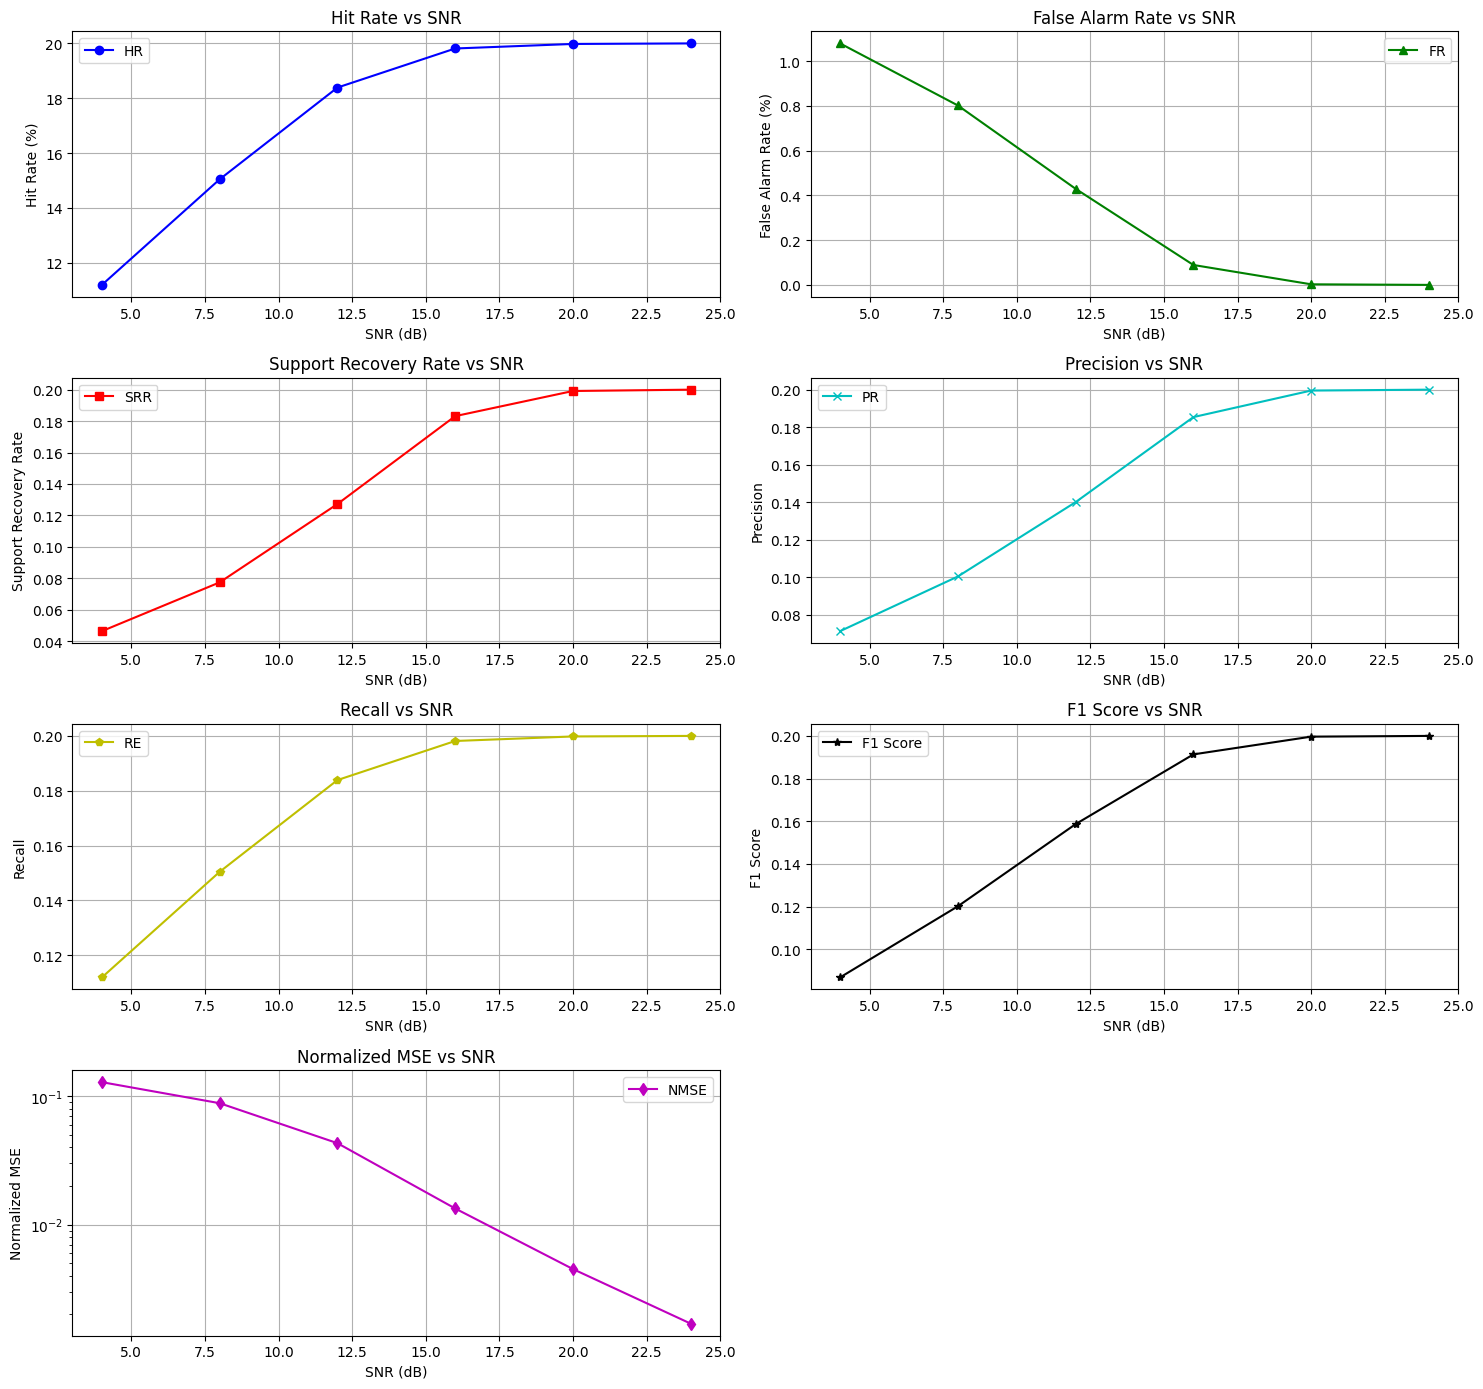

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
snr_values = snr_db_array

# Create subplots for different performance metrics
plt.figure(figsize=(15, 14))

# Plot Hit Rate (HR)
plt.subplot(4, 2, 1)
plt.plot(snr_values, avg_hr, marker='o', linestyle='-', color='b', label='HR')
plt.xlabel("SNR (dB)")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate (FR)
plt.subplot(4, 2, 2)
plt.plot(snr_values, avg_fr, marker='^', linestyle='-', color='g', label='FR')
plt.xlabel("SNR (dB)")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Support Recovery Rate (SRR)
plt.subplot(4, 2, 3)
plt.plot(snr_values, avg_srr, marker='s', linestyle='-', color='r', label='SRR')
plt.xlabel("SNR (dB)")
plt.ylabel("Support Recovery Rate")
plt.title("Support Recovery Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Precision (PR)
plt.subplot(4, 2, 4)
plt.plot(snr_values, avg_pr, marker='x', linestyle='-', color='c', label='PR')
plt.xlabel("SNR (dB)")
plt.ylabel("Precision")
plt.title("Precision vs SNR")
plt.grid(True)
plt.legend()

# Plot Recall (RE)
plt.subplot(4, 2, 5)
plt.plot(snr_values, avg_re, marker='p', linestyle='-', color='y', label='RE')
plt.xlabel("SNR (dB)")
plt.ylabel("Recall")
plt.title("Recall vs SNR")
plt.grid(True)
plt.legend()

# Plot F1 Score (F1)
plt.subplot(4, 2, 6)
plt.plot(snr_values, avg_f1, marker='*', linestyle='-', color='k', label='F1 Score')
plt.xlabel("SNR (dB)")
plt.ylabel("F1 Score")
plt.title("F1 Score vs SNR")
plt.grid(True)
plt.legend()

# Plot Normalized MSE (NMSE)
plt.subplot(4, 2, 7)
plt.plot(snr_values, avg_nmse, marker='d', linestyle='-', color='m', label='NMSE')
plt.xlabel("SNR (dB)")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs SNR")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_res_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

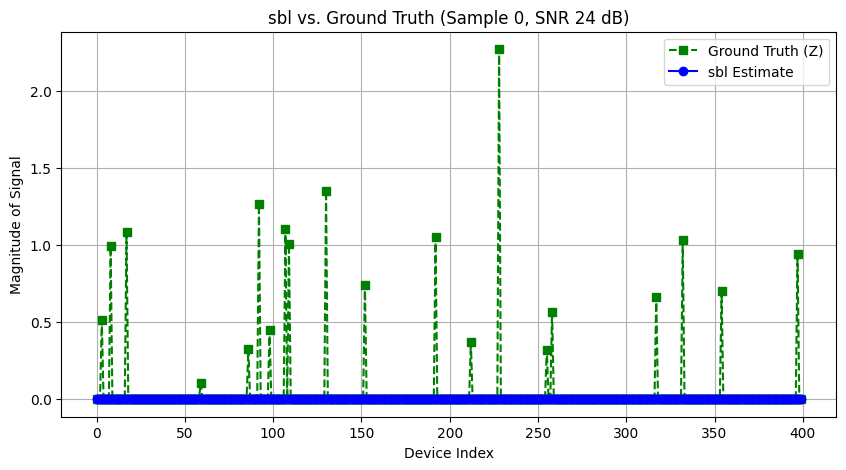

In [11]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_res_vs_ground_truth(z_res, all_z, sample_index, snr_index, snr_value)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_res_vs_ground_truth(gamma_res, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_res[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


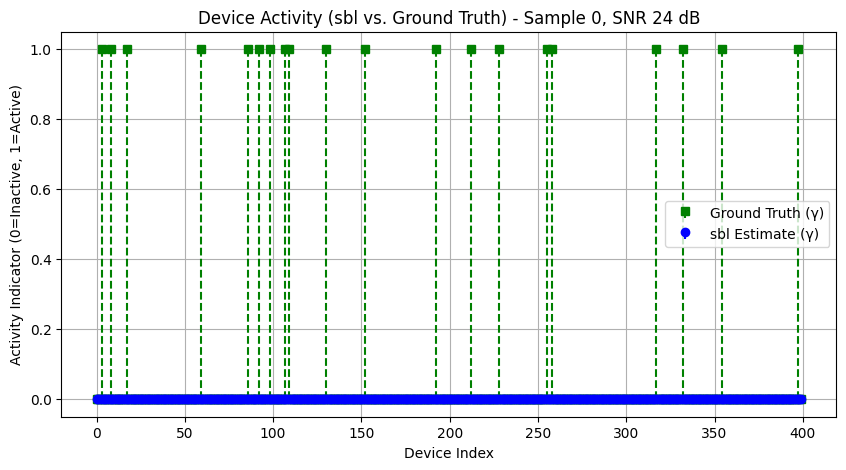

In [13]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_res_vs_ground_truth(gamma_res, all_gamma, sample_index, snr_index, snr_value)